In [1]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt
import tqdm.notebook
import scipy.integrate

In [2]:
matplotlib.rcParams.update({'font.size': 6, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

# Temporal metaplasticity under a uniform distribution in the dark

Here, we simulate modifications to the two implementations of temporal metaplasticity that could successfully match the plasticity rule to a characteristic feedback delay in the circuit model.

In [3]:
# Time vector 

dt = 1e-4
T_max = 0.2
t = np.arange(0, int(T_max/dt))*dt

In [5]:
# uniform distribution
uniform_distr = np.ones(len(t))
uniform_distr /= np.sum(uniform_distr)

In [392]:
# calculate cdf
uniform_cdf = np.cumsum(uniform_distr)
uniform_cdf_fn = lambda r: np.interp(r, t, uniform_cdf,left=0,right=1)

# function that samples from the distribution given a percentile input
get_interval_unif = lambda r: np.interp(r, uniform_cdf, t)

## Asymmetric single timer selection

We use a single timer selection mechanism in which there is both a narrow and a broad window. The narrow window is slightly asymmetric ($\tau_l > \tau_r$), leading to a tendency to reduce the peak given a uniform distribution. The weight of the broad window is very small, and helps move $\tau_\text{peak}$ to find the peak timing value faster than diffusion alone.

In [8]:
# Load the empirical PF-CF interval distribution from the integrated circuit model
# using the single timer adjustment mechanism
empirical_distr = np.load('../circuit-model/timer-selection-biochem-hist.npy')

# distribution was calculated with 100 bins
t_empirical = np.linspace(0, 0.2, 100)


In [9]:
# cdf
empirical_cdf = np.cumsum(empirical_distr)
empirical_cdf_fn = lambda r: np.interp(r, t_empirical, empirical_cdf,left=0,right=1)

# function to sample from the distribution
get_interval_empirical = lambda r: np.interp(r, empirical_cdf, t_empirical)

In [121]:
# shape of eligibility window
idealized_integrator = lambda t, t_p,sigma2: np.exp(-(t-t_p)**2/(2*sigma2**2))

# idealized version of temporal metaplasticity rule
def tempRule(tau,tau_peak,median_weight=0,window_left=20e-3,window_right=20e-3):
    # Idealized broad window: lower threshold if CF occurs before current peak time
    # and raise threshold if CF occurs after current peak time
    broad_window = np.sign(tau - tau_peak)
    
    # Idealized narrow window: restrict to window size
    narrow_window = broad_window*(t >= tau_peak - window_left)*(t<= tau_peak + window_right)
    return narrow_window * (1-median_weight) + broad_window * median_weight

def simulateTimerAdjustmentPeak(get_interval, N_sims = 10, its = 5000, 
                                dtp_ = 1e-3, min_tp = 0, max_tp = T_max, report_its = 100,
                               window_left = 20e-3, window_right = 20e-3,
                                median_weight = 0.01, initial_value = 0):
    # get_interval: function that takes a number in (0,1) and returns a sample from the distribution
    # N_sims: number of simulations (tau_peak is reset)
    # its: iterations of temporal metaplasticity (PF-CF pairings) within a simulation
    # dtp_: amplitude of temporal metaplasticity window (max amount to move tau_peak after a pairing)
    # min_tp, max_tp: minimum and maximum values of tau_peak
    # report_its: number of iterations after which results are saved
    # window_left, window_right: size of left and right lobes of narrow window
    # median_weight: relative magnitude of broad window; narrow window has 1 - median_weight
    # initial_value: of tau_peak
    
    # initialize results vector
    tps = np.zeros((N_sims, int(its/report_its)))
    
    # initialize initial tau_peak values for simulations
    if len(initial_value) == 0:
        initial_value = min_tp
    elif len(initial_value) == 1:
        initial_value = np.ones(N_sims)*initial_value

    for n in tqdm.notebook.trange(N_sims):
        report_ind = 0
        if len(initial_value) == N_sims:
            tp = initial_value[n]
        else:
            tp = initial_value

        for it in tqdm.notebook.trange(its-1, leave=False):
            cf_time = get_interval(rng.random())
            
            # Calculate update to tau_peak
            dtp = dtp_*tempRule(cf_time, tp, median_weight=median_weight, 
                                window_left=window_left, window_right=window_right)
            tp += dtp

            if it % report_its == 0:
                tps[n, report_ind] = tp
                report_ind += 1
    return tps

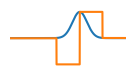

In [250]:
# Plot rule and the approximate eligibility window that would produce it using
# the biochemical network model

plt.figure(figsize=(1.5,0.75))
plt.plot(t,idealized_integrator(t,0.12,12.5e-3))
plt.plot(t, tempRule(t,0.12,window_left=40e-3, window_right=39e-3, median_weight=5e-3))
plt.xlim([0,0.2])
plt.axis('off')
plt.savefig('figures/ideal-selection-wide.pdf')

### Normal visual experience (with empirical distribution)

In [122]:
# Run the simulation

rng = np.random.default_rng(seed=0)
window_left, window_right = 40e-3, 39e-3
median_weight = 5e-3
tps_ideal_asym = simulateTimerAdjustmentPeak(get_interval_empirical,dtp_=5e-4, initial_value=[0.], 
                                             window_left=window_left, window_right=window_right,
                                               its=4000000, N_sims=10,median_weight=median_weight, report_its=10000)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

  0%|          | 0/3999999 [00:00<?, ?it/s]

In [123]:
# np.save('files/dark/tps_ideal_asym_large_empirical.npy', tps_ideal_asym)
# tps_ideal_asym = np.load('files/dark/tps_ideal_asym_large_empirical.npy')

In [124]:
trial_t = np.arange(tps_ideal_asym.shape[1])

### Plot flow field
If the cumulative distribution function is $F(\tau)$, the expected change in $\tau_\text{peak}$ from the broad window is
$$
    \langle\Delta\tau_\text{peak}\rangle_\text{broad}(\tau_\text{peak}) = -F(\tau_\text{peak}) + (1-F(\tau_\text{peak})) = 1 - 2F(\tau_\text{peak}),
$$
and the expected change from the narrow window is
$$
\begin{align*}
    \langle\Delta\tau_\text{peak}\rangle_\text{narrow}(\tau_\text{peak}) &= -(F(\tau_\text{peak}) - F(\tau_\text{peak}-\tau_l)) + (F(\tau_\text{peak}+\tau_r) - F(\tau_\text{peak})) \\
    &= F(\tau_\text{peak}+\tau_r) + F(\tau_\text{peak}-\tau_l) - 2F(\tau_\text{peak}).
\end{align*}
$$

Using this, we can plow a flow field.

In [398]:
expected_delta_tp_fn = lambda tp,fn: (median_weight*(1-2*fn(tp))+
                                (1-median_weight)*(fn(tp-window_left) +
                                                  fn(tp+window_right) - 2*fn(tp)))

expected_delta_tp_unif = lambda tp: expected_delta_tp_fn(tp, uniform_cdf_fn)
expected_delta_tp_empirical = lambda tp: expected_delta_tp_fn(tp, empirical_cdf_fn)

In [135]:
report_its = 10000
total_its = 4e6

In [229]:
tp_phase = np.linspace(0.01, 0.19, 10)
tt_phase = np.linspace(total_its*0.1, total_its*0.9, 4)

tpp, ttt = np.meshgrid(tp_phase, tt_phase)

In [230]:
dtpp = expected_delta_tp_empirical(tpp)
dttt = np.ones(ttt.shape)

dtpp_norm = dtpp/np.sqrt(dtpp**2 + dttt**2)
dttt_norm = dttt/np.sqrt(dtpp**2 + dttt**2)

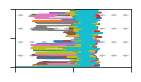

In [141]:
# Plot individual trajectories
plt.figure(figsize=(1.5,0.75))
plt.quiver(tpp, ttt, dtpp_norm, dttt_norm, angles='xy', pivot='middle', color=(0.7,)*3)
plt.plot([0.12,]*2, [0, trial_t[-1]], c='r')
plt.plot([0.0615,]*2, [0, trial_t[-1]], c='r') # c=(0.3,)*3)
c = np.linspace(0,0.8,10)
for i in range(10):
    plt.plot(tps_ideal_asym[i,:], trial_t*report_its,lw=1) # , c=[c[i],]*3)


plt.xlim([0, 0.2])
plt.ylim([0, total_its])

ax = plt.gca()
ax.set_yticks([0, total_its/2, total_its])
ax.set_yticklabels([])
ax.set_xticks([0, 0.1, 0.2])
ax.set_xticklabels([])
# plt.savefig('figures/ideal-adjustment-narrow-asym-phase-empirical.pdf')

In [148]:
tps_ideal_asym_empirical_mu = np.mean(tps_ideal_asym,axis=0)
tps_ideal_asym_empirical_std = np.std(tps_ideal_asym,axis=0)

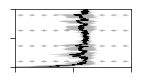

In [232]:
# Plot mean + sd
plt.figure(figsize=(1.5,0.75))
plt.quiver(tpp, ttt, dtpp_norm, dttt_norm, angles='xy', pivot='middle', units='x',color=(0.7,)*3)

plt.plot(tps_ideal_asym_empirical_mu, trial_t*report_its, c='k',lw=0.5)
# plt.plot((tp_ideal_asym_unif_mu-tp_ideal_asym_unif_std), trial_t*1000, c=(0.5,)*3)
# plt.plot((tp_ideal_asym_unif_mu+tp_ideal_asym_unif_std), trial_t*1000, c=(0.5,)*3)
# plt.plot(thresholds_ideal_2_mu, trial_t)z
plt.fill_betweenx(trial_t*report_its, tps_ideal_asym_empirical_mu - tps_ideal_asym_empirical_std,
                  tps_ideal_asym_empirical_mu + tps_ideal_asym_empirical_std, facecolor=(0.7,)*3 )
# plt.fill_betweenx(trial_t, thresholds_ideal_2_mu - thresholds_ideal_2_std,thresholds_ideal_2_mu + thresholds_ideal_2_std, facecolor='C1', alpha=0.3 )

plt.xlim([0, 0.2])
plt.ylim([0, total_its])

ax = plt.gca()
ax.set_yticks([0, total_its/2, total_its])
ax.set_yticklabels([])
ax.set_xticks([0, 0.1, 0.2])
ax.set_xticklabels([])
# plt.savefig('figures/ideal-selection-narrow-asym-phase-empirical-mu-long.pdf')

In [93]:
tps_ideal_asym_empirical_mu = np.mean(tps_ideal_asym,axis=0)

In [151]:
np.mean(tps_ideal_asym_empirical_mu[-10:])

np.float64(0.12187812500335116)

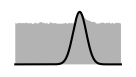

In [153]:
# Plot distribution and final state of eligibility window
plt.figure(figsize=(1.5,0.75))
plt.fill_between(t_empirical, 0, empirical_distr, facecolor=(0.7,)*3)
plt.axis('off')
ax=plt.twinx()
plt.plot(t, idealized_integrator(t, np.mean(tps_ideal_asym_empirical_mu[-10:]),0.0125),c='k')
plt.axis('off')

# plt.savefig('figures/ideal-adjustment-narrow-asym-eligibility-empirical.pdf')

### In the dark (with uniform distribution)

In [235]:
rng = np.random.default_rng(seed=42)
tp_ideal_asym_unif = simulateTimerAdjustmentPeak(get_interval_unif,dtp_=5e-4, initial_value=[0.12], 
                                                 window_left=window_left, window_right=window_right,
                                               its=1000000, N_sims=10,median_weight=median_weight, report_its=10000)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

In [236]:
# np.save('files/dark/tps_ideal_asym_large_unif_1m.npy', tp_ideal_asym_unif)
# tp_ideal_asym_unif = np.load('files/dark/tps_ideal_asym_large_unif_1m.npy')

### Plot flow field

In [239]:
report_its = 10000
total_its = 1e6

In [240]:
tp_phase = np.linspace(0.01, 0.19, 10) # 8
tt_phase = np.linspace(total_its*0.1, total_its*0.9, 4)

tpp, ttt = np.meshgrid(tp_phase, tt_phase)

In [241]:
dtpp = expected_delta_tp_unif(tpp)
dttt = np.ones(ttt.shape)

dtpp_norm = dtpp/np.sqrt(dtpp**2 + dttt**2)
dttt_norm = dttt/np.sqrt(dtpp**2 + dttt**2)

In [242]:
trial_t = np.arange(tp_ideal_asym_unif.shape[1])
# total_its = 2e6

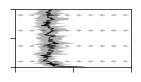

In [243]:
plt.figure(figsize=(1.5,0.75))
plt.quiver(tpp, ttt, dtpp_norm, dttt_norm, angles='xy', pivot='middle', color=(0.7,)*3)
# plt.plot([0.05,]*2, [0, trial_t[-1]], c='r')
# plt.plot([0.0615,]*2, [0, trial_t[-1]], c='r') # c=(0.3,)*3)
# c = np.linspace(0,0.8,10)
# for i in range(10):
#     plt.plot(thresholds_ideal_asym[i,::1000], trial_t[::1000]) # , c=[c[i],]*3)

plt.plot(tp_ideal_asym_unif_mu, trial_t*report_its, c='k',lw=0.5)
# plt.plot((tp_ideal_asym_unif_mu-tp_ideal_asym_unif_std), trial_t*1000, c=(0.5,)*3)
# plt.plot((tp_ideal_asym_unif_mu+tp_ideal_asym_unif_std), trial_t*1000, c=(0.5,)*3)
# plt.plot(thresholds_ideal_2_mu, trial_t)
plt.fill_betweenx(trial_t*report_its, tp_ideal_asym_unif_mu - tp_ideal_asym_unif_std,tp_ideal_asym_unif_mu + tp_ideal_asym_unif_std, facecolor='k', alpha=0.3 )
# plt.fill_betweenx(trial_t, thresholds_ideal_2_mu - thresholds_ideal_2_std,thresholds_ideal_2_mu + thresholds_ideal_2_std, facecolor='C1', alpha=0.3 )

plt.xlim([0, 0.2])
plt.ylim([0, total_its])

ax = plt.gca()
ax.set_yticks([0, total_its/2, total_its])
ax.set_yticklabels([])
ax.set_xticks([0, 0.1, 0.2])
ax.set_xticklabels([])
plt.savefig('figures/ideal-adjustment-narrow-asym-phase-unif-long-1m.pdf')

In [403]:
tp_ideal_asym_unif_mu = np.mean(tp_ideal_asym_unif, axis=0)
tp_ideal_asym_unif_std = np.std(tp_ideal_asym_unif, axis=0)

np.mean(tp_ideal_asym_unif_mu[-10:])

np.float64(0.059179775000975)

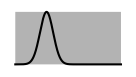

In [248]:
# Plot final state of eligibility window
plt.figure(figsize=(1.5,0.75))
plt.fill_between(t, 0, uniform_distr, facecolor=(0.7,)*3)
plt.axis('off')
ax=plt.twinx()
plt.plot(t, idealized_integrator(t, np.mean(tp_ideal_asym_unif_mu[-10:]),0.0125),c='k')
plt.axis('off')

# plt.savefig('figures/ideal-adjustment-narrow-asym-eligibility-unif.pdf')

# Biased multiple timer selection rule

The winner-take-all rule can be modified by decreasing the amount by which the timer peaking closest to 0 ms changes its coupling strength ($\delta_1$) when it is out-of-sync from the postsynaptic spike. Here this change $\delta_1$ is 99% of the $\delta$ value for the other timers.

In [251]:
## Generate timer bank
num_ideal_timers = 11
timers = np.zeros((num_ideal_timers, len(t)))
centers = np.linspace(0, 0.2, num_ideal_timers+1)[:-1]
width = centers[1]/2
centers += width
for i in range(num_ideal_timers):
    timers[i,:] = np.exp(-(t - centers[i])**2/(2*(width)**2))

In [253]:
# Pre-calculate which timer is most active at every time in the time range
timer_max = np.zeros((num_ideal_timers, len(t)))
for i in range(len(t)):
    timer_max[np.argmax(timers[:,i]),i] = 1

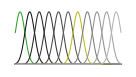

In [254]:
plt.figure(figsize=(1.5,0.75))

c_ = np.linspace(0, 0.7,num_ideal_timers)
for i in range(num_ideal_timers):
    if i == 0:
        c_str = 'C2'
    elif i == 6:
        c_str = 'C8'
    else:
        c_str = [c_[i],]*3
    plt.plot(t, timers[i,:], c=c_str,lw=0.75)
plt.axis('off')
plt.savefig('figures/ideal-selection-biased-timers.pdf')

In [294]:
def selectionFixedBias(v_initial, get_interval, its=5000000, dv_max = 1e-4, report_its = 10000, dv_zero = 0.9e-4):
    """Simulate ATTRAP with fixed update method of timer selection mechanism.
    
    Arguments:
    v_initial -- initial vector of eligibility coupling weights
    distr -- distribution of PF/CF intervals
    its -- total number of PF/CF presentations (iterations) to simulate
    dv -- "Delta", the amount by which to decrease coupling weights for inactive timers
    report_its -- Frequency (in iterations) of reporting output weight vector
    
    Returns:
    v -- final weight vector
    v_all -- weight vector reported at intervals specified by report_its
    """
    
    # cdf = np.cumsum(distr/np.sum(distr))

    # Use CDF to draw intervals randomly from distribution given uniform random variables (see Methods)
    # get_interval = lambda r: np.interp(r, cdf, t)
    # get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)
    
    # Used for reporting weight values periodically
    report_counter = 0
    report_index = 1

    num_states = timers.shape[0]
    
    dv = dv_max*np.ones(num_states)
    dv[0] = dv_zero
    # active_v_threshold = dv/num_states

    # num_updates = np.zeros(num_states)

    v_all = np.zeros((num_states, int(its/report_its)+1))
    v_all[:,0] = np.copy(v_initial)
    v = np.copy(v_initial)

    for it in tqdm.notebook.trange(its):
        # Calculate values of most active basis function
        # given random draw of PF/CF interval
        cf_spike_ind = np.digitize(get_interval(rng.random()), t)-1
        timer_vals = timers[:,cf_spike_ind]

        # Get index of most active timer
        active_timer = np.argmax(timer_vals)

        # Shouldn't end up with negative weights
        timers_to_update = (v>0)
        timers_to_update[active_timer] = False
        num_active_timers = np.sum(timers_to_update)

        if num_active_timers > 0:
            dv_minus = np.zeros(num_states)
            # Decrease coupling weights of all timers except the most active (ind_to_increase)
            dv_minus[timers_to_update] = np.minimum(v[timers_to_update], dv[timers_to_update])
            dv_minus[active_timer] = 0

            # Add weight changes
            v -= dv_minus
            
            v[active_timer] += np.sum(dv_minus)

        report_counter += 1
        # Save current weight vector periodically
        if report_counter == report_its:
            v_all[:, report_index] = np.copy(v)
            report_counter = 0
            report_index += 1
    return v, v_all

In [284]:
# Load distribution from integrated circuit model simulation
empirical_distr = np.load('../behavior-learning/files/integrated simulation/poisson sparse/hist_history.npy')

empirical_pdf = np.sum(empirical_distr[:,1,:,-1],axis=0)
empirical_pdf /= np.sum(empirical_pdf)
empirical_cdf = np.cumsum(empirical_pdf)
t_empirical = np.linspace(0, 0.2, 100)

get_interval_empirical = lambda r: np.interp(r, empirical_cdf, t_empirical)

### Normal visual experience (using empirical distribution)

We start from an initial state with all coupling strength on the first timer element (closes to 0 ms).

In [371]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_fixed_ideal_peaked, v_fixed_ideal_all_peaked = selectionFixedBias(v_initial, get_interval_empirical, its=5000000, report_its=10000,
                                                  dv_max=1e-4, dv_zero = 0.99e-4)

  0%|          | 0/5000000 [00:00<?, ?it/s]

In [385]:
# np.save('files/dark/v_fixed_ideal_all_empirical.npy', v_fixed_ideal_all_peaked)
# np.save('files/dark/v_fixed_ideal_empirical.npy', v_fixed_ideal_peaked)

# v_fixed_ideal_all_peaked = np.load('files/dark/v_fixed_ideal_all_empirical.npy')
# v_fixed_ideal_peaked = np.load('files/dark/v_fixed_ideal_empirical.npy')

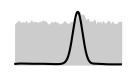

In [405]:
# Eligibility window after light experience

plt.figure(figsize=(1.5,0.75))
plt.fill_between(t_empirical, 0, empirical_pdf, color=(0.8,)*3)
plt.axis('off')
ax = plt.twinx()
ax.plot(t, v_fixed_ideal_peaked@timers,c='k')
plt.axis('off');
# plt.savefig('figures/ideal-selection-biased-weights-window.pdf')

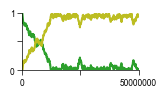

In [407]:
# Change in coupling strengths for timer 1 (closest to 0 ms) and timer 7 (closes to 120 ms)

plt.figure(figsize=(1.5,0.75))

it_report = 100000
x = np.arange(v_fixed_ideal_all_peaked.shape[1])*it_report
plt.plot(x, v_fixed_ideal_all_peaked[0,:], c='C2')
plt.plot(x, v_fixed_ideal_all_peaked[6,:], c='C8')
ax = plt.gca()
plt.ylim([0,1])
plt.xlim([0, x[-1]])
ax.set_xticks([0, x[-1]/2, x[-1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([0,'',x[-1]])
# ax.set_xticklabels([])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0,'',1]);
# ax.set_yticklabels([])
# plt.savefig('figures/ideal-selection-biased-weights-empirical.pdf')

### Dark (using uniform distribution)

Here, we start from the coupling strengths reached after the light experience.

In [382]:
v_initial = v_fixed_ideal_peaked # np.zeros(num_ideal_timers)
# v_initial[0] = 1

v_fixed_ideal_unif, v_fixed_ideal_all_unif = selectionFixedBias(v_initial, get_interval_unif, its=5000000, report_its=10000,
                                                  dv_max=1e-4, dv_zero = 0.99e-4)

  0%|          | 0/5000000 [00:00<?, ?it/s]

In [386]:
# np.save('files/dark/v_fixed_ideal_all_uniform.npy', v_fixed_ideal_all_unif)
# np.save('files/dark/v_fixed_ideal_uniform.npy', v_fixed_ideal_unif)

# v_fixed_ideal_all_unif = np.load('files/dark/v_fixed_ideal_all_uniform.npy')
# v_fixed_ideal_unif = np.load('files/dark/v_fixed_ideal_uniform.npy')

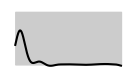

In [383]:
# Eligibility window after dark experience

plt.figure(figsize=(1.5,0.75))
plt.fill_between(t, 0, uniform_distr, color=(0.8,)*3)
plt.axis('off')
ax = plt.twinx()
ax.plot(t, v_fixed_ideal_unif@timers,c='k',clip_on=False)
plt.ylim([0,1])
plt.axis('off')
# plt.savefig('figures/ideal-selection-biased-weights-unif-window.pdf')

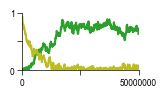

In [384]:
# Change in coupling strengths over the dark period
plt.figure(figsize=(1.5,0.75))

it_report = 100000
x = np.arange(v_fixed_ideal_all_unif.shape[1])*it_report
plt.plot(x, v_fixed_ideal_all_unif[0,:],c='C2')
plt.plot(x, v_fixed_ideal_all_unif[6,:], c='C8')
# plt.plot(x, v_fixed_ideal_all_unif[-2,:], c='C9')

ax = plt.gca()
plt.ylim([0,1])
plt.xlim([0, x[-1]])
ax.set_xticks([0, x[-1]/2, x[-1]])
ax.set_xticklabels([0,'',x[-1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0,'',1]);

# plt.savefig('figures/ideal-selection-biased-weights-unif.pdf')